In [155]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import difi

In [54]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [4]:
%%time
neo_path = "/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S0/"
all_neo_obs = [pd.read_hdf(neo_path + f"visit-{int(file * 1e4):07}.h5") for file in range(208)]

CPU times: user 10.5 s, sys: 918 ms, total: 11.5 s
Wall time: 11.5 s


In [26]:
%%time
mba_paths = [f"/data/epyc/projects/jpl_survey_sim/10yrs/detections/march_start_v2.1/S1_{i:02d}/" for i in range(14)]
all_mba_obs = [pd.read_hdf(mba_paths[i] + f"visit-{int(file * 1e4):07}.h5") for file in [0] for i in range(14)]

CPU times: user 7.34 s, sys: 853 ms, total: 8.19 s
Wall time: 8.19 s


In [5]:
obs = pd.concat(all_neo_obs)
obs["night"] = (obs["FieldMJD"] - 0.5).astype(int) - 59638
obs.sort_values("FieldMJD", inplace=True)

In [6]:
observations = obs[["ObjID", "night", "FieldMJD"]]
observations.reset_index(drop=True, inplace=True)
observations["obs_id"] = observations.index.values

/tmp/ipykernel_31276/4012404709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observations["obs_id"] = observations.index.values


In [7]:
column_mapping={
    "obs_id": "obs_id",
    "truth": "ObjID",
    "time": "FieldMJD",
    "night": "night"
}

In [9]:
%%time
all_truths, findable_observations, summary = difi.analyzeObservations(observations=observations,
                         metric="nightly_linkages",
                         column_mapping=column_mapping,
                         detection_window=15,
                         ignore_after_detected=True)

CPU times: user 1min 48s, sys: 3.49 s, total: 1min 51s
Wall time: 1min 17s


In [21]:
def night_found(obs_ids, observations):
    return np.unique(observations.loc[obs_ids][column_mapping["night"]].values)[2]

In [25]:
%%time
obs_night_found = findable_observations["obs_ids"].apply(night_found, observations=observations)

CPU times: user 17.3 s, sys: 61.3 ms, total: 17.4 s
Wall time: 17.1 s


In [26]:
findable_observations["night_found"] = obs_night_found

In [ ]:
all_truths.to_hdf("difi_MBAs_10yrs.h5", key="all_truths")
findable_observations.to_hdf("difi_MBAs_10yrs.h5", key="findable_observations")

In [27]:
findable_observations

,index,ObjID,obs_ids,window_start_night,night_found
0,0,S000003Wa,"[548, 599, 1300, 1339, 2141, 2202, 4639, 4666,...",0,9
1,1,S000005la,"[1550, 1592, 2411, 2415, 2474, 2477, 2525, 254...",0,11
2,2,S000006Ya,"[2014, 2098, 2126, 2185, 4472, 4473, 4484, 448...",0,14
3,3,S000006ba,"[1433, 1434, 1518, 2398, 2403, 2457, 2515, 257...",0,12
4,4,S000006wa,"[2529, 2587, 2608, 2622, 5211, 5219, 5363, 538...",0,13
...,...,...,...,...,...
34526,0,S00002nba,"[2409329, 2409371, 2412703, 2412705, 2412734, ...",3637,3651
34527,1,S0000dula,"[2409505, 2409555, 2409570, 2414265, 2414302, ...",3637,3651
34528,2,S0000eXda,"[2406566, 2406640, 2406644, 2414284, 2414288, ...",3637,3651
34529,0,S0000CQTa,"[2408429, 2408445, 2408536, 2408570, 2414840, ...",3639,3652


In [127]:
which_night, n_found = np.unique(obs_night_found, return_counts=True)

In [128]:
TOTAL_NEO = 268511
neos_left = TOTAL_NEO
neos_left_each_night = np.zeros(3653)
detections_each_night = np.zeros(3653)
for night in range(3653):
    this_night = which_night == night
    if any(this_night):
        neos_left -= n_found[this_night][0]
        detections_each_night[night] = n_found[this_night][0]
    
    neos_left_each_night[night] = neos_left

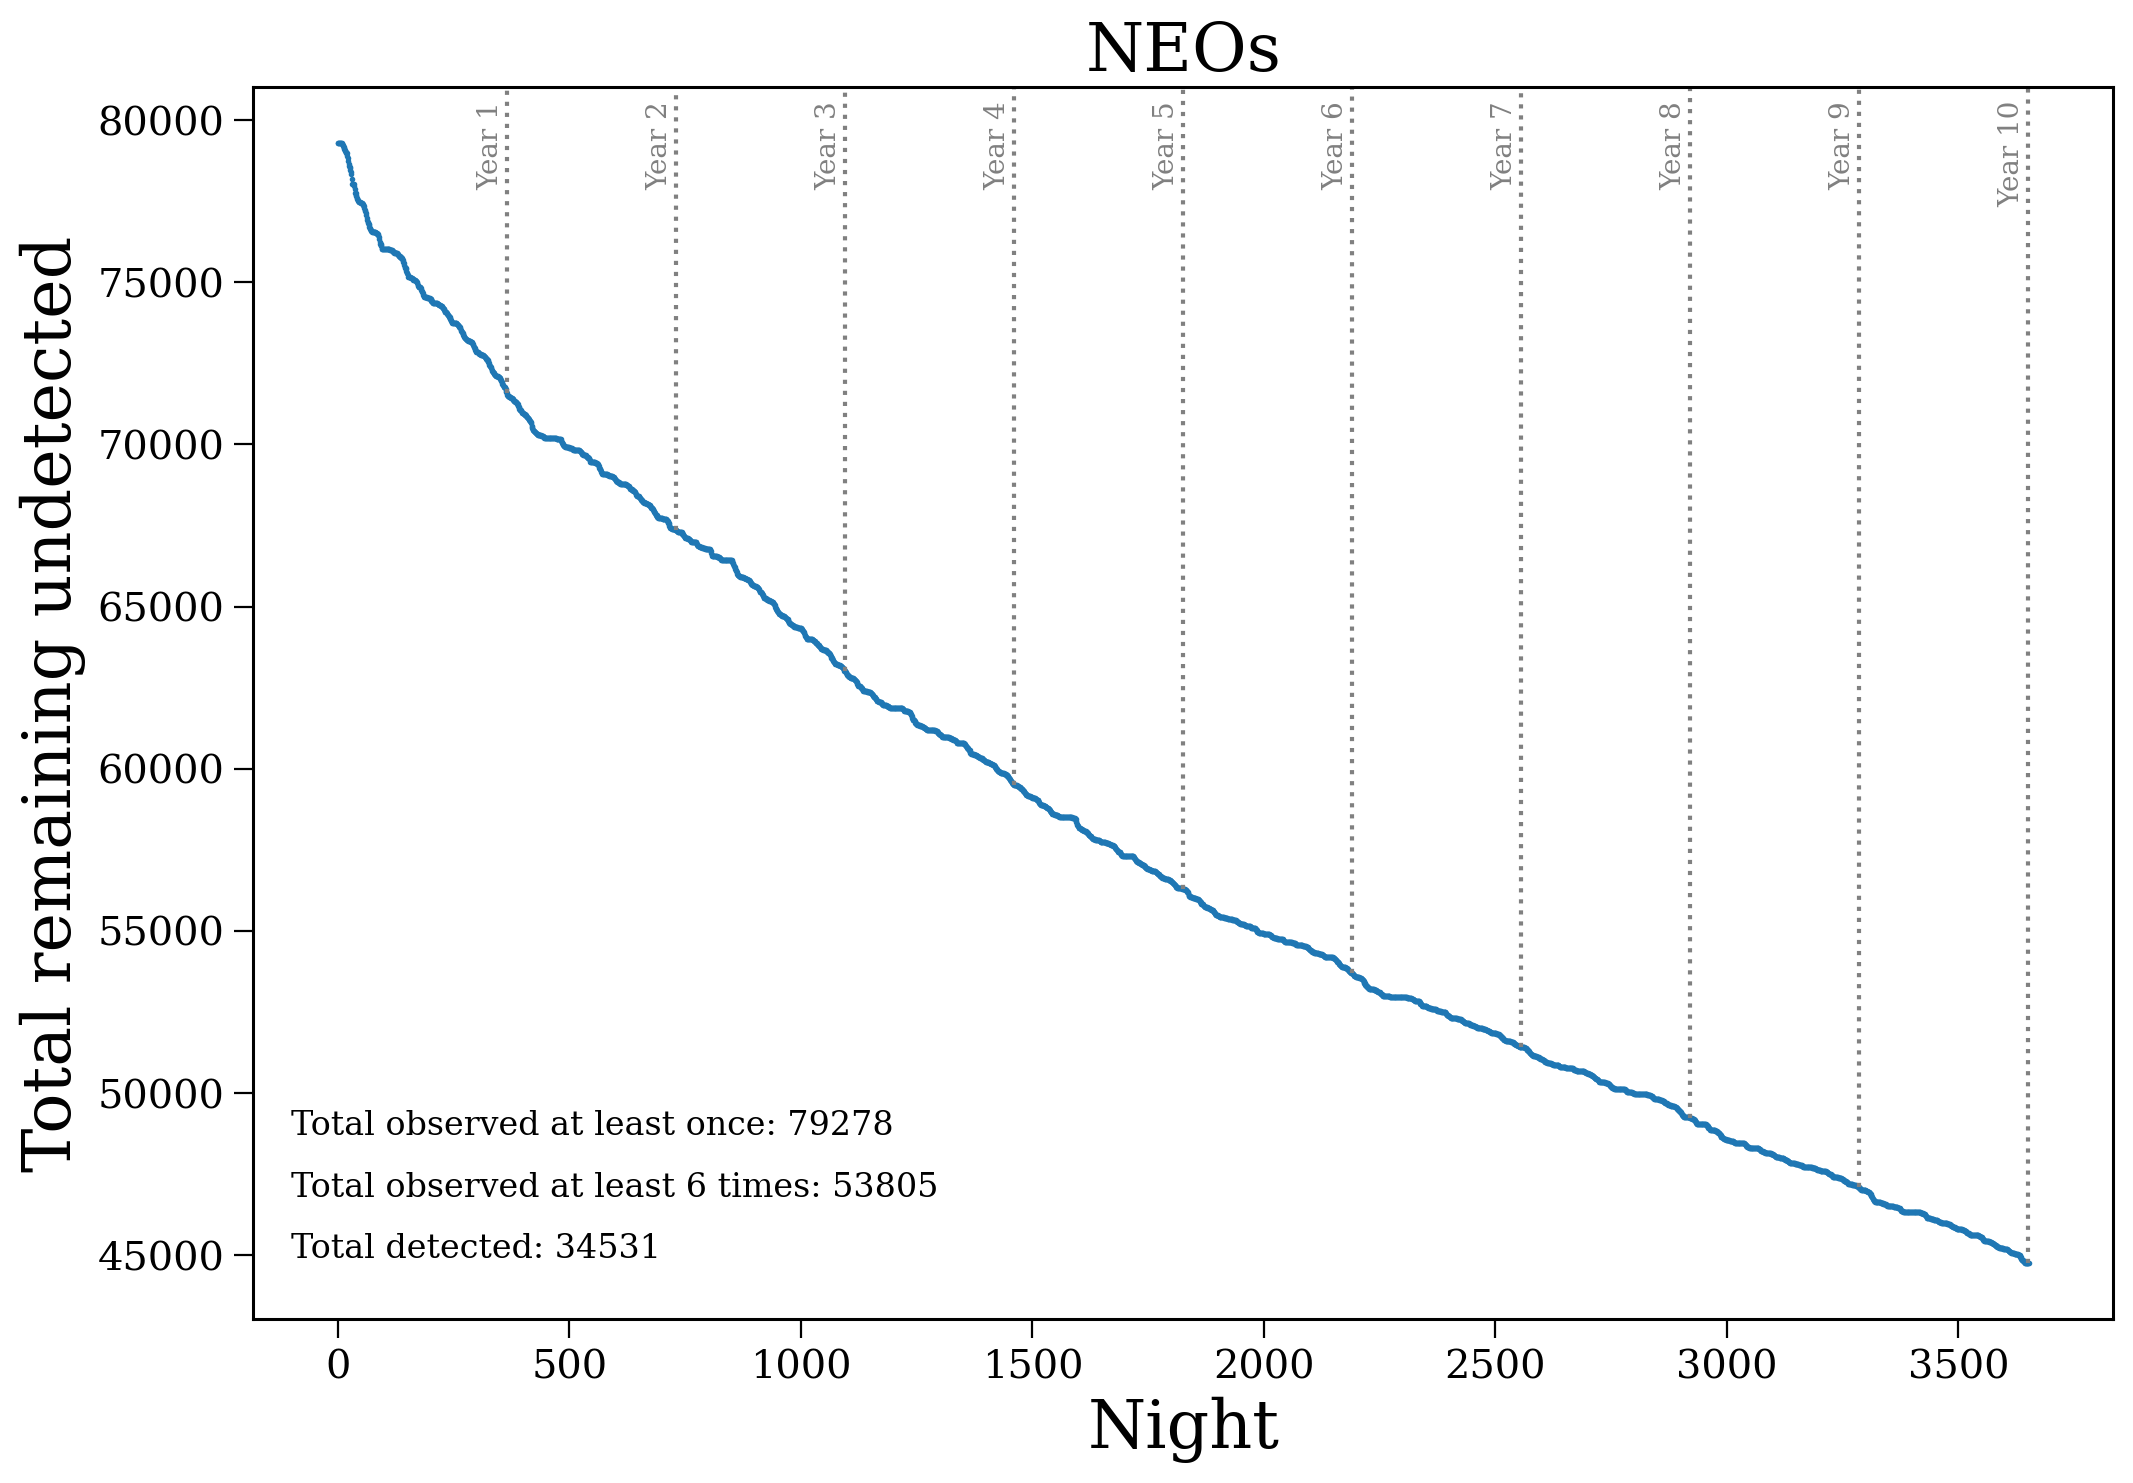

In [90]:
fig, ax = plt.subplots()

ax.scatter(range(3653), neos_left_each_night, s=1)

ax.set_xlabel("Night")
ax.set_ylabel("Total remaining undetected")

ylims = ax.get_ylim()

for year in range(1, 11):
    year_ind = year * 365
    ax.plot([year_ind, year_ind], [neos_left_each_night[year_ind], neos_left_each_night[0] * 2], color="grey", linestyle="dotted")
    ax.annotate(f"Year {year}", xy=(year * 365 - 5, ylims[-1] * 0.995), rotation=90, ha="right", va="top", color="grey")

ax.annotate(f"Total observed at least once: {len(all_truths)}", xy=(0.02, 0.15), xycoords="axes fraction", fontsize="large")
ax.annotate(f"Total observed at least 6 times: {(all_truths['num_obs'] >= 6).sum()}", xy=(0.02, 0.1), xycoords="axes fraction", fontsize="large")
ax.annotate(f"Total detected: {(all_truths['findable'] == 1).sum()}", xy=(0.02, 0.05), xycoords="axes fraction", fontsize="large")
    
ax.set_ylim(ylims)

ax.set_title("NEOs", fontsize=fs)

plt.show()

In [138]:
mba_ids = np.load("all_difi_MBA_ids.npy")
mba_night_found = np.load("all_difi_MBA_nfs.npy")

In [139]:
which_night, n_found = np.unique(mba_night_found, return_counts=True)

In [140]:
TOTAL_MBA = 13883389 - 14 * 2
mbas_left = TOTAL_MBA
mbas_left_each_night = np.zeros(3653)
mba_detections_each_night = np.zeros(3653)
for night in range(3653):
    this_night = which_night == night
    if any(this_night):
        mbas_left -= n_found[this_night][0]
        mba_detections_each_night[night] = n_found[this_night][0]
    
    mbas_left_each_night[night] = mbas_left

In [113]:
ratio = detections_each_night / mba_detections_each_night
plt.scatter(range(3653ratio[~np.isnan(ratio)]

/tmp/ipykernel_31276/890598533.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ratio = detections_each_night / mba_detections_each_night
/tmp/ipykernel_31276/890598533.py:1: RuntimeWarning: invalid value encountered in true_divide
  ratio = detections_each_night / mba_detections_each_night


array([1.58333333e+00, 3.13725490e-01, 7.05882353e-01, ...,
       0.00000000e+00, 2.10985301e-04, 2.49283310e-04])

In [136]:
mba_detections_each_night

array([    0.,     0.,     0., ...,  3875., 14219.,  8023.])

In [148]:
ratio = detections_each_night / mba_detections_each_night

/tmp/ipykernel_31276/762872485.py:1: RuntimeWarning: divide by zero encountered in true_divide
  ratio = detections_each_night / mba_detections_each_night
/tmp/ipykernel_31276/762872485.py:1: RuntimeWarning: invalid value encountered in true_divide
  ratio = detections_each_night / mba_detections_each_night


Require certain number of detections

In [164]:
def weekly_mean(x, bad_weather=[], half_size=3):
    y = np.repeat(np.nan, len(x))
    for i in range(len(x)):
        if i not in bad_weather:
            inds = np.arange(max(0, i - half_size), min(i + half_size + 1, len(x)))
            inds = inds[~np.isin(inds, bad_weather)]
            y[i] = np.mean(x[inds])
    return y

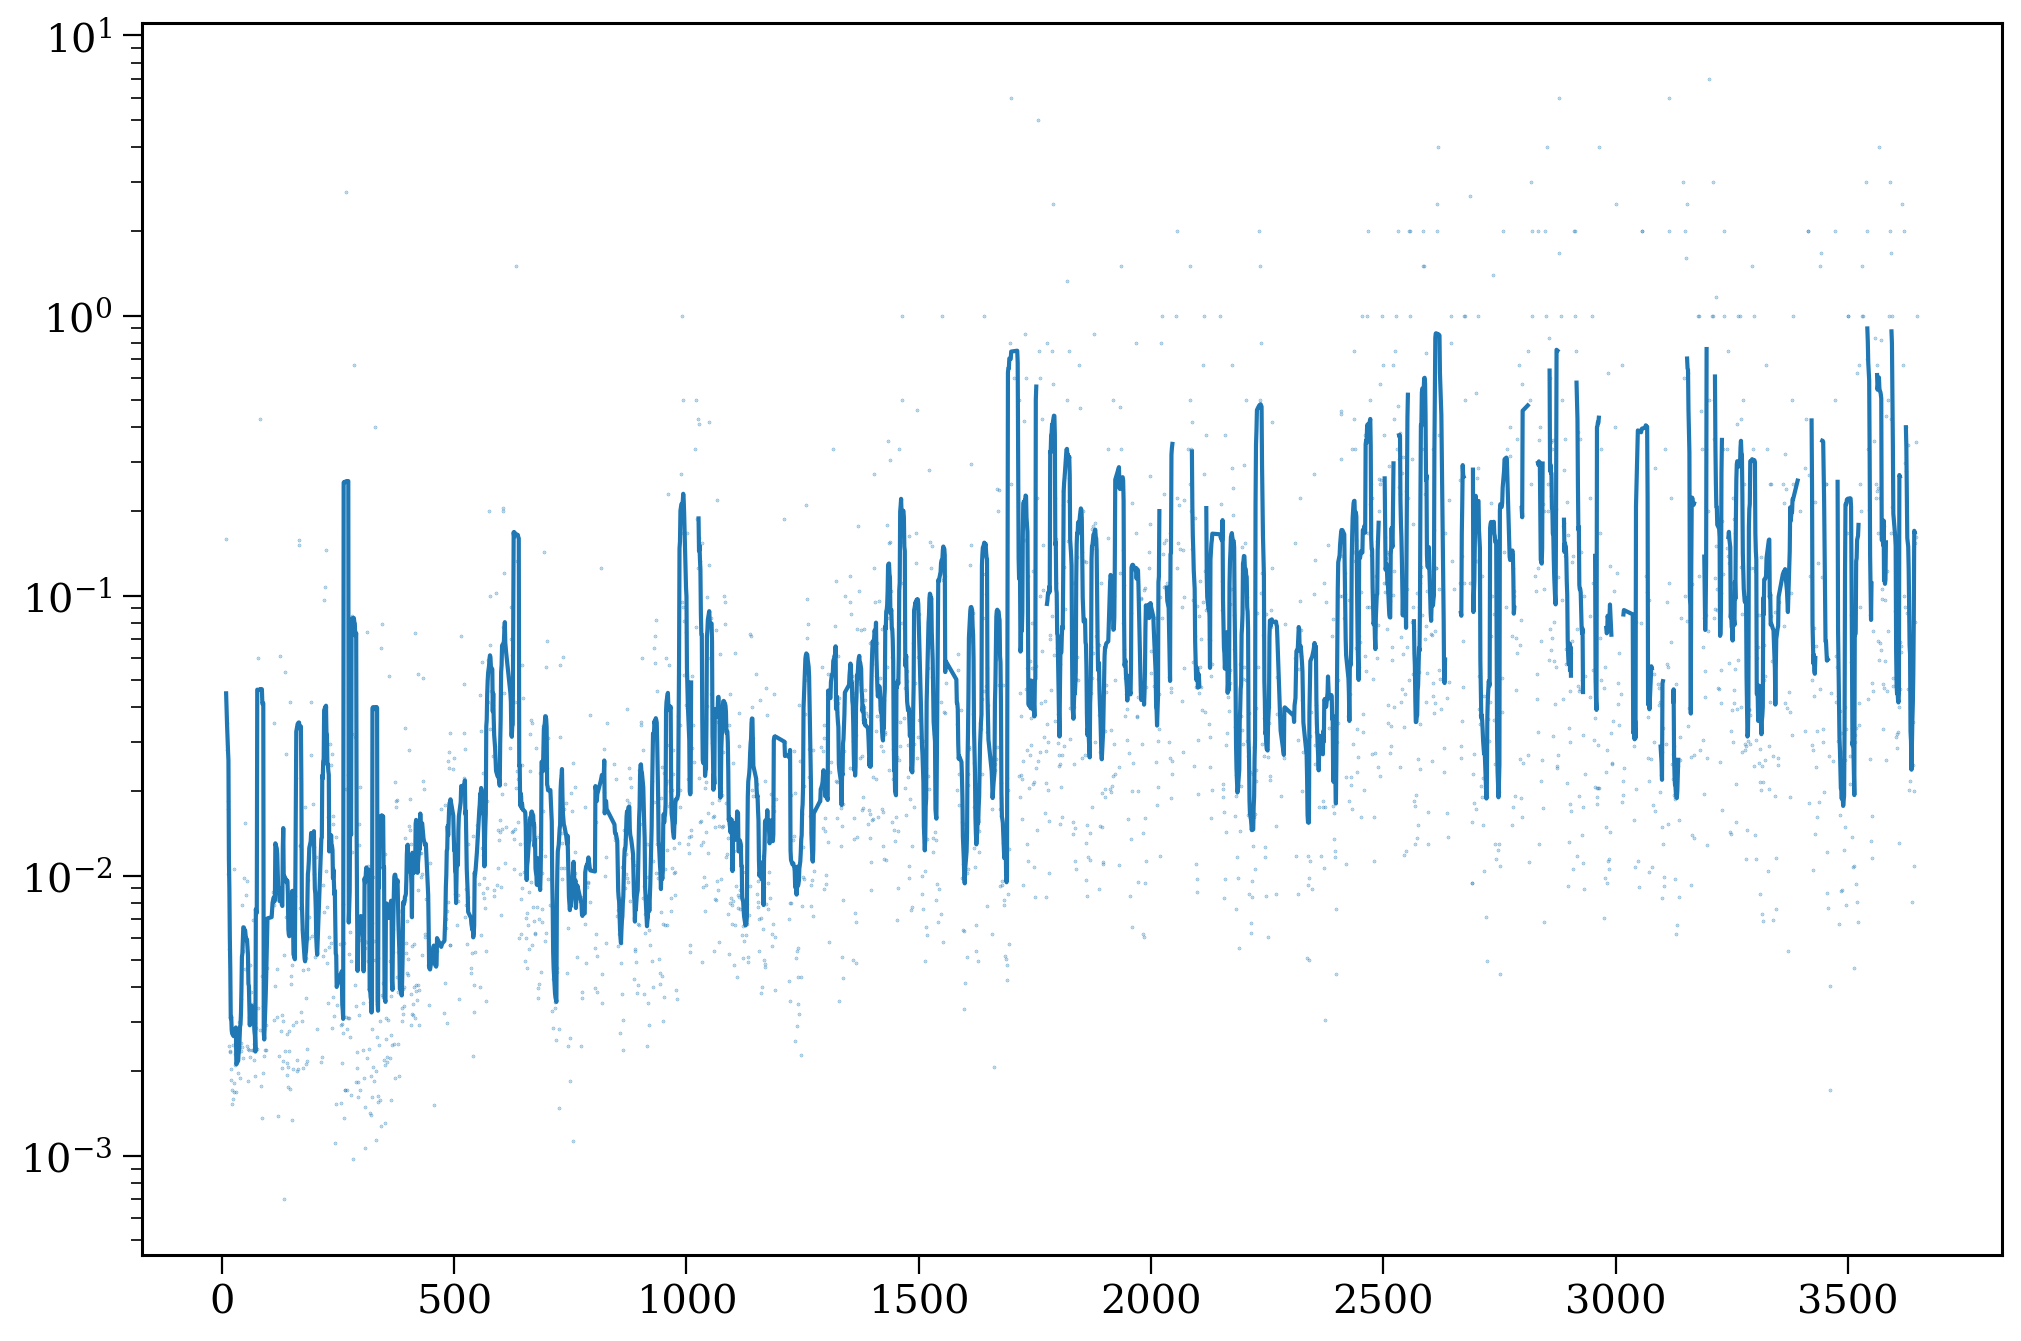

In [167]:
plt.scatter(np.arange(3653)[~np.isnan(ratio)], ratio[~np.isnan(ratio)], s=0.1, alpha=0.5)
plt.plot(np.arange(3653)[~np.isnan(ratio)], weekly_mean(ratio[~np.isnan(ratio)], half_size=5))
plt.yscale("log")

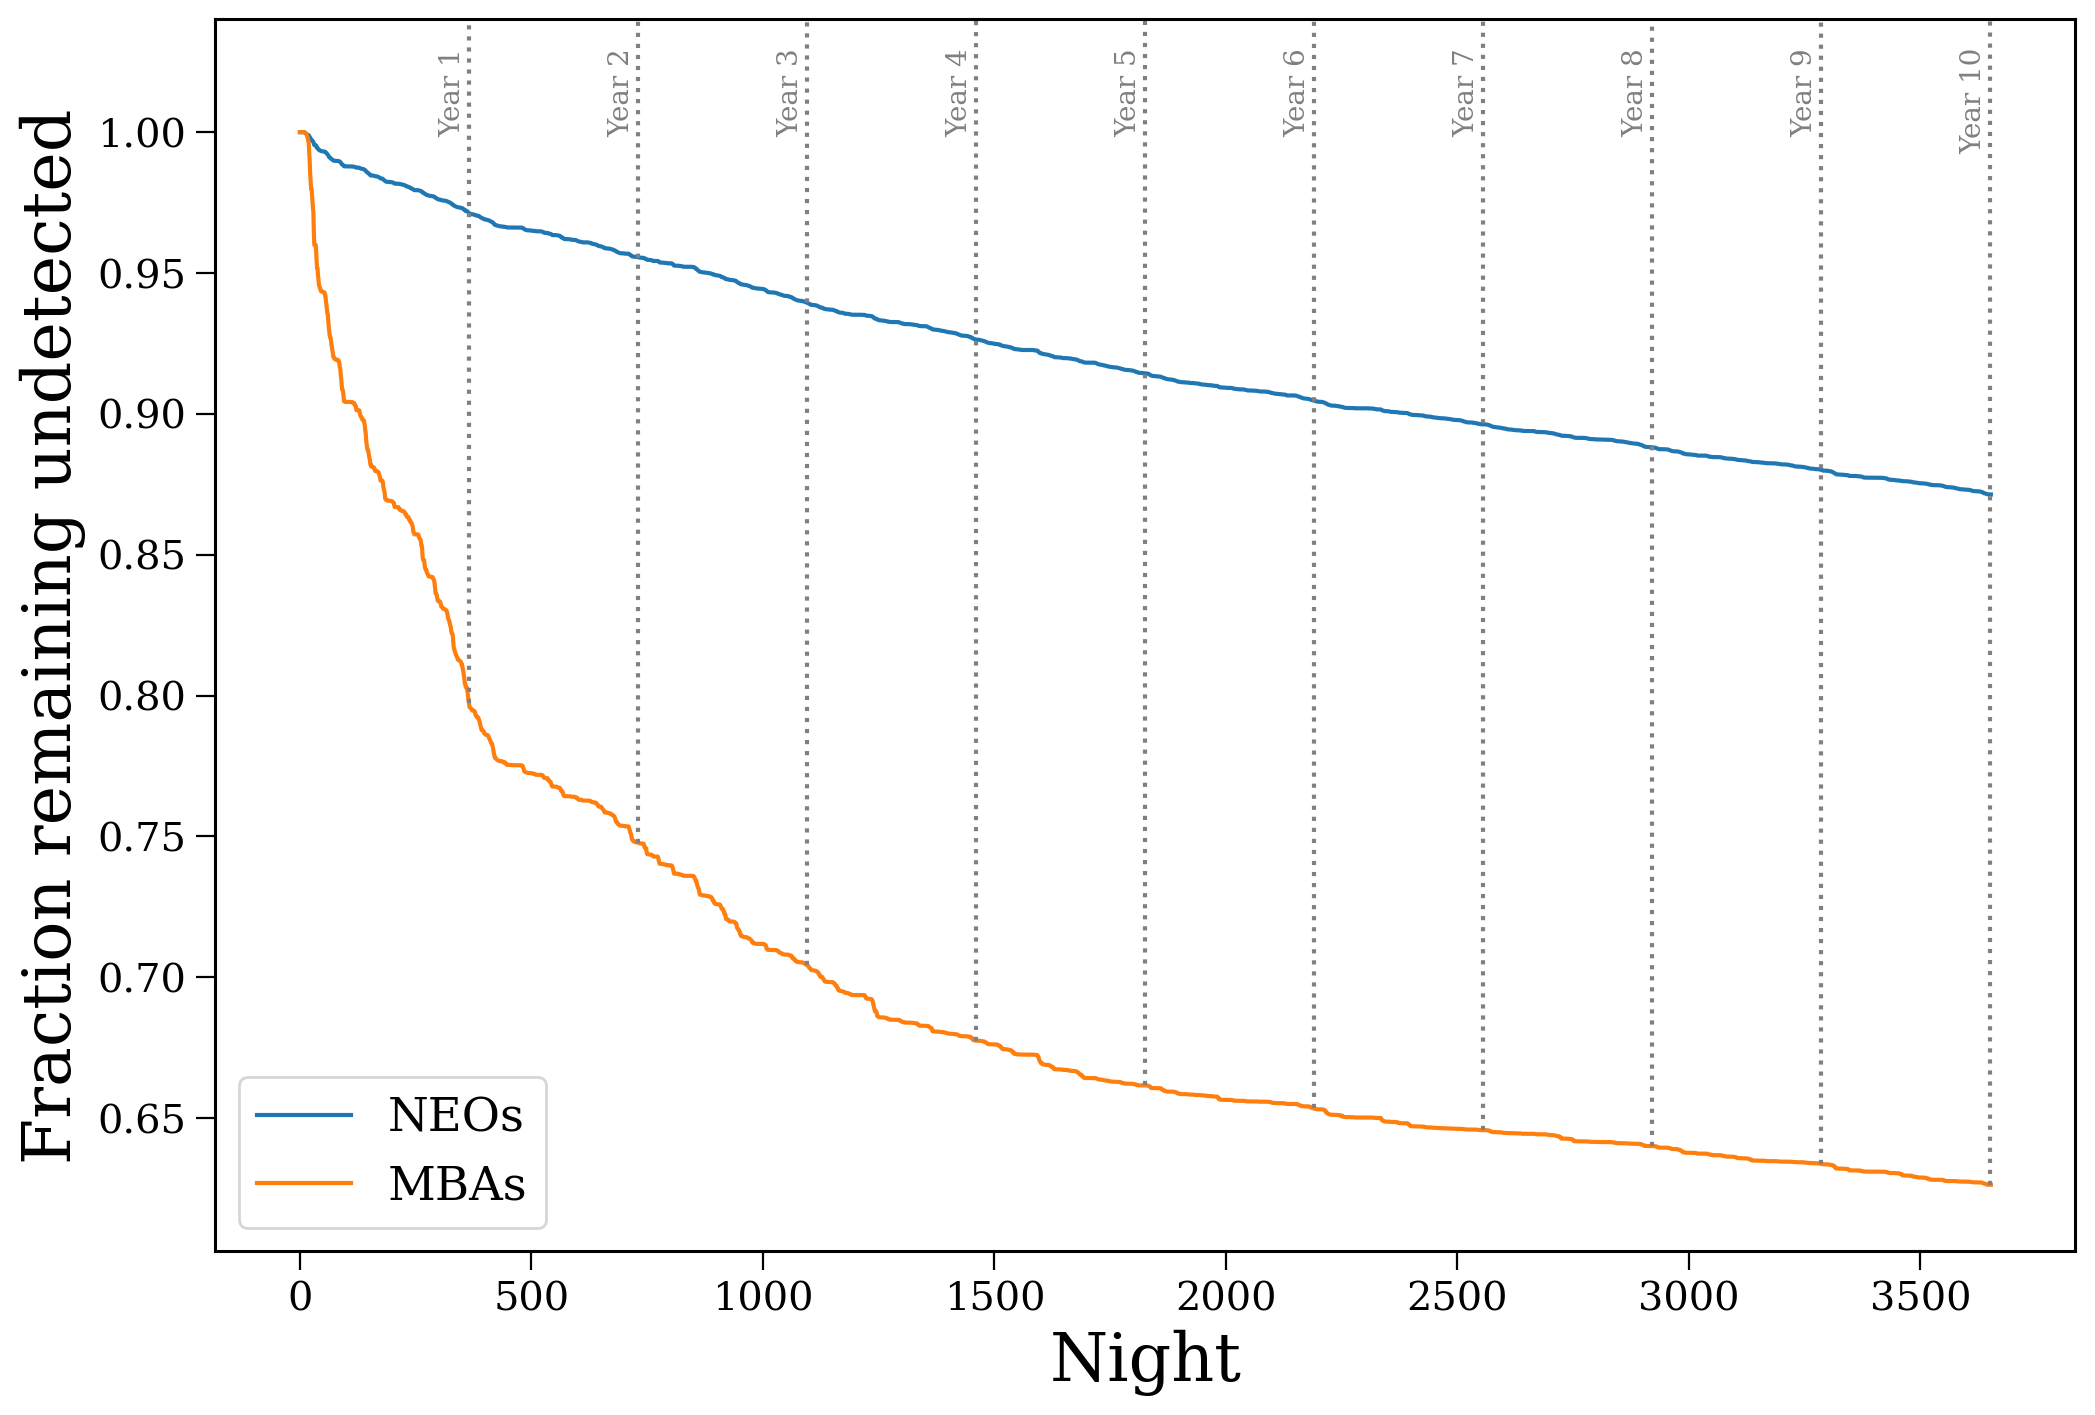

In [168]:
fig, ax = plt.subplots()

ax.plot(range(3653), neos_left_each_night / TOTAL_NEO, label="NEOs")
ax.plot(range(3653), mbas_left_each_night / TOTAL_MBA, label="MBAs")

ax.set_xlabel("Night")
ax.set_ylabel("Fraction remaining undetected")

for year in range(1, 11):
    year_ind = year * 365
    lower = min(neos_left_each_night[year_ind] / TOTAL_NEO, mbas_left_each_night[year_ind] / TOTAL_MBA)
    ax.plot([year_ind, year_ind], [lower, 1.1], color="grey", linestyle="dotted")
    ax.annotate(f"Year {year}", xy=(year * 365 - 5, 1.03), rotation=90, ha="right", va="top", color="grey")

# ax.annotate(f"Total observed at least once: {len(all_truths)}", xy=(0.02, 0.15), xycoords="axes fraction", fontsize="large")
# ax.annotate(f"Total observed at least 6 times: {(all_truths['num_obs'] >= 6).sum()}", xy=(0.02, 0.1), xycoords="axes fraction", fontsize="large")
# ax.annotate(f"Total detected: {(all_truths['findable'] == 1).sum()}", xy=(0.02, 0.05), xycoords="axes fraction", fontsize="large")

ax.legend(loc="lower left", fontsize=0.7*fs)
    
ax.set_ylim(top=1.04)

plt.savefig("../paper/figures/cumulative_detections.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [176]:
TOTAL_NEO_LSST = TOTAL_NEO - neos_left
TOTAL_MBA_LSST = TOTAL_MBA - mbas_left

In [179]:
TOTAL_NEO_LSST

34531

In [182]:
mbas_left_each_night - mbas_left

array([5187337., 5187337., 5187337., ...,       0.,       0.,       0.])

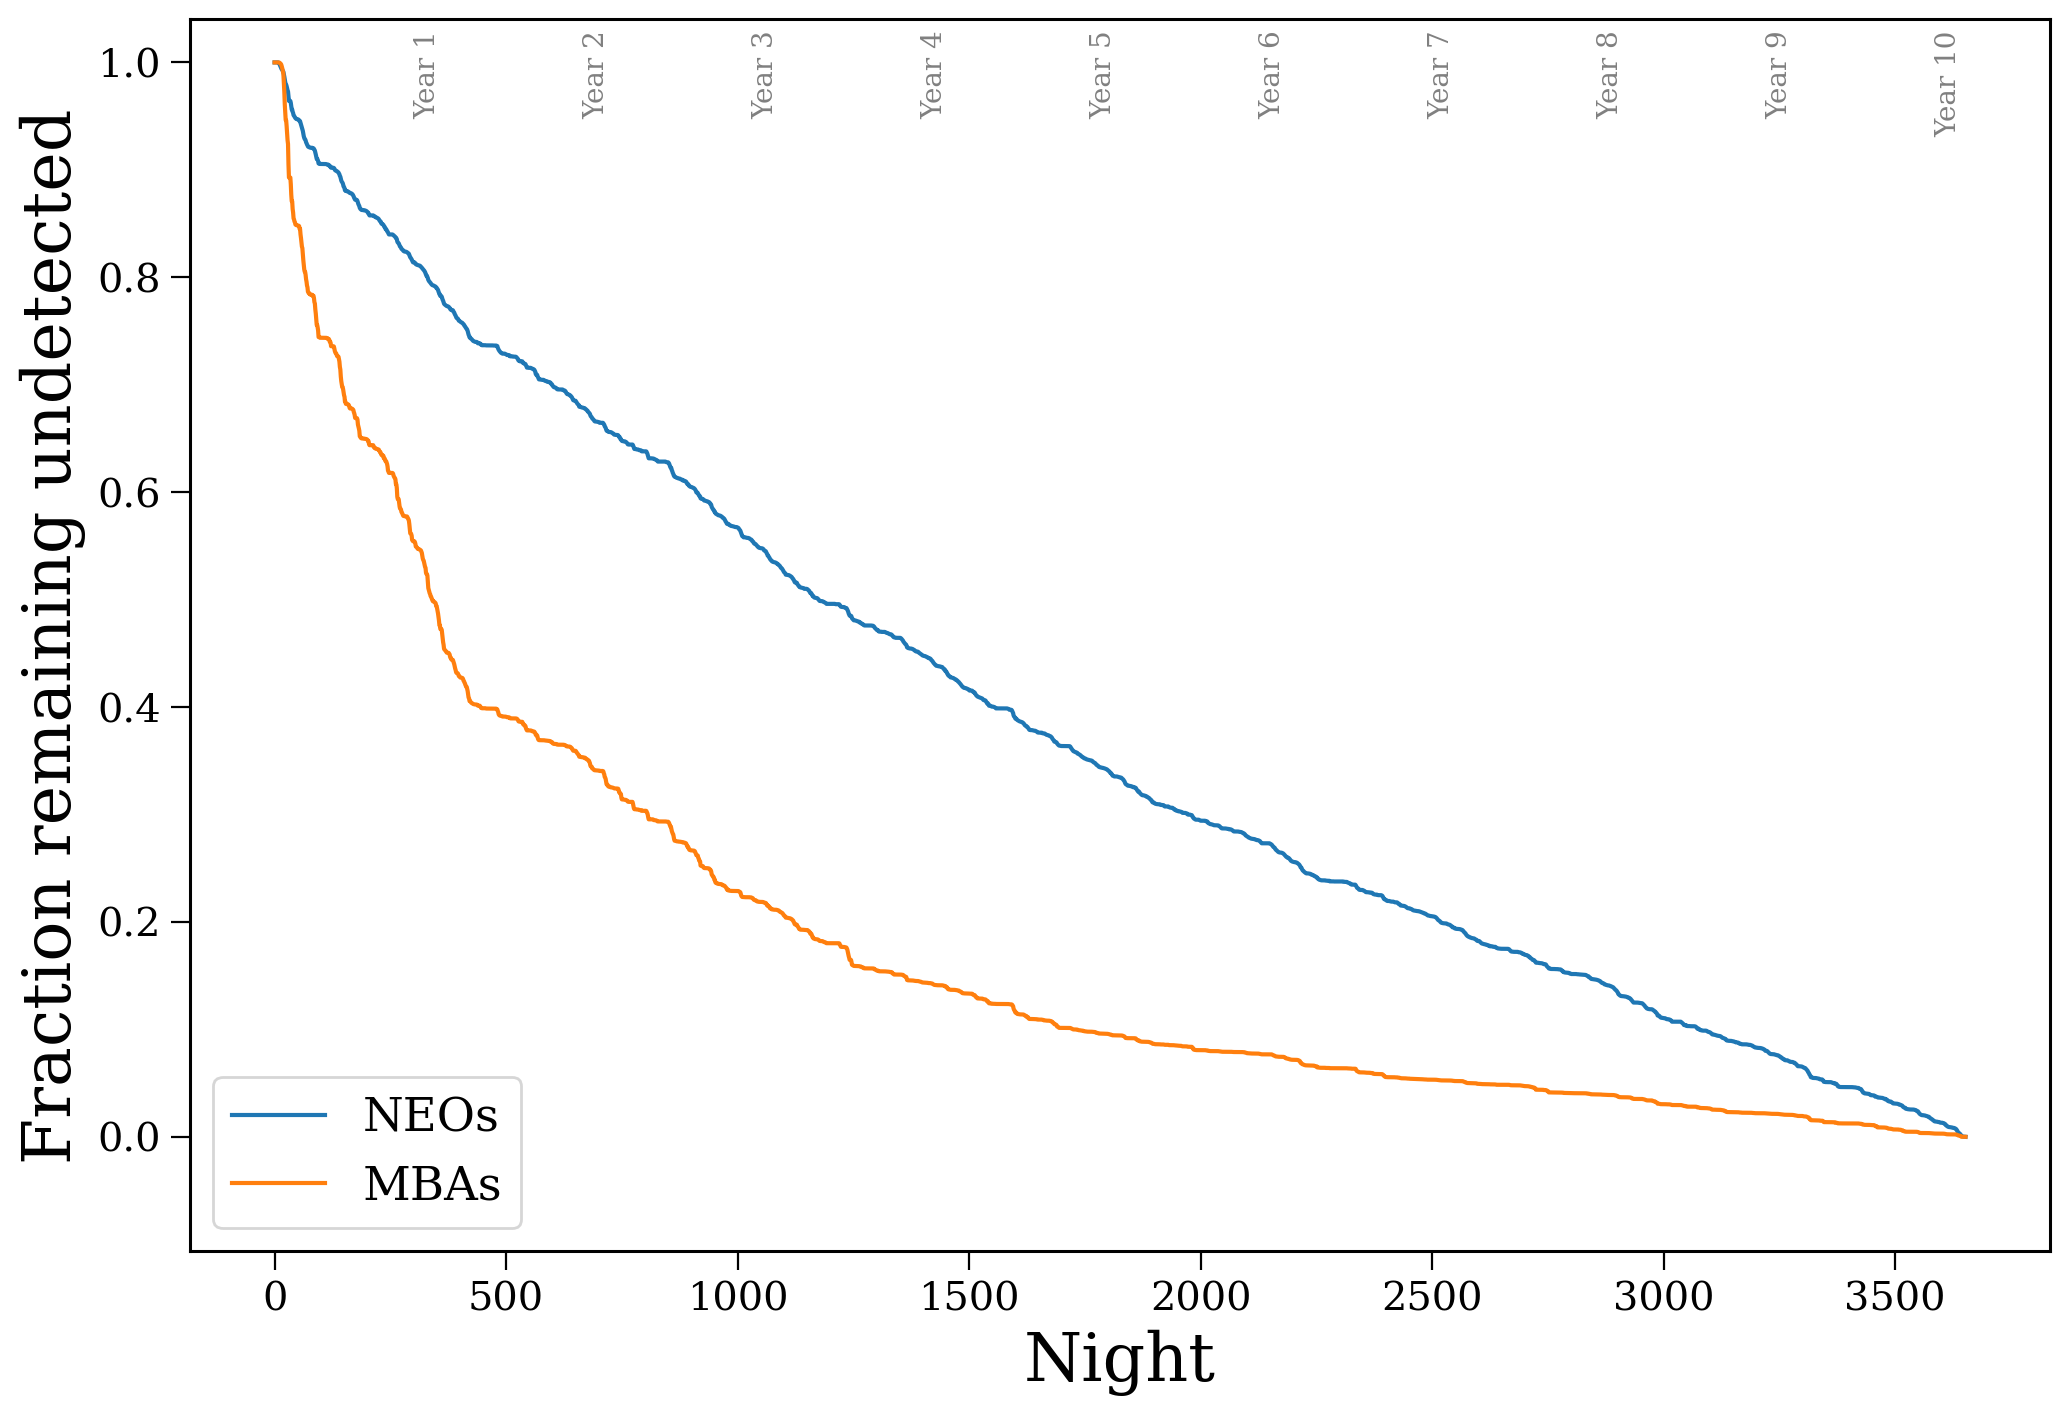

In [184]:
fig, ax = plt.subplots()

ax.plot(range(3653), (neos_left_each_night - neos_left) / TOTAL_NEO_LSST, label="NEOs")
ax.plot(range(3653), (mbas_left_each_night - mbas_left) / TOTAL_MBA_LSST, label="MBAs")

ax.set_xlabel("Night")
ax.set_ylabel("Fraction remaining undetected")

for year in range(1, 11):
    year_ind = year * 365
    lower = min(neos_left_each_night[year_ind] / TOTAL_NEO_LSST, mbas_left_each_night[year_ind] / TOTAL_MBA_LSST)
    ax.plot([year_ind, year_ind], [lower, 1.1], color="grey", linestyle="dotted")
    ax.annotate(f"Year {year}", xy=(year * 365 - 5, 1.03), rotation=90, ha="right", va="top", color="grey")

ax.legend(loc="lower left", fontsize=0.7*fs)
    
ax.set_ylim(top=1.04)

# plt.savefig("../paper/figures/cumulative_detections.pdf", format="pdf", bbox_inches="tight")

plt.show()

H < 22 normalisation for NEOs